<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [K3WINE1] - Wine quality prediction with a Dense Network (DNN)
  <!-- DESC -->  Another example of regression, with a wine quality prediction, using Keras 3 and PyTorch
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predict the **quality of wines**, based on their analysis
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Wine Quality datasets](https://archive.ics.uci.edu/ml/datasets/wine+Quality)** are made up of analyses of a large number of wines, with an associated quality (between 0 and 10)  
This dataset is provide by :  
Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez  
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal, @2009  
This dataset can be retreive at [University of California Irvine (UCI)](https://archive.ics.uci.edu/dataset/186/wine+quality)


Due to privacy and logistic issues, only physicochemical and sensory variables are available  
There is no data about grape types, wine brand, wine selling price, etc.

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (score between 0 and 10)

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import pandas as pd

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('K3WINE1')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3WINE1
Run dir              : ./run/K3WINE1
Datasets dir         : /data/datasets-fidle
Start time           : 22/09/25 16:35:33
Hostname             : 523f51ec6e3b (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3WINE1/figs (False)
keras                : 3.7.0
numpy                : 2.2.1
sklearn              : 1.6.0
yaml                 : 6.0.2
matplotlib           : 3.10.0
pandas               : 2.2.3
torch                : 2.5.1+cpu


Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [2]:
fit_verbosity = 1
dataset_name  = 'winequality-red.csv'

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('fit_verbosity', 'dataset_name')

## Step 2 - Retrieve data

In [4]:
data = pd.read_csv(f'{datasets_dir}/WineQuality/origine/{dataset_name}', header=0,sep=';')

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data :  0   Shape is :  (1599, 12)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the quality

In [5]:
# ---- Split => train, test
#
data       = data.sample(frac=1., axis=0)     # Shuffle
data_train = data.sample(frac=0.8, axis=0)    # get 80 %
data_test  = data.drop(data_train.index)      # test = all - train

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('quality',  axis=1)
y_train = data_train['quality']
x_test  = data_test.drop('quality',   axis=1)
y_test  = data_test['quality']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (1599, 12)
x_train :  (1279, 11) y_train :  (1279,)
x_test  :  (320, 11) y_test  :  (320,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [6]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.33,0.53,0.27,2.55,0.09,15.93,46.98,1.00,3.31,0.66,10.42
std,1.75,0.17,0.19,1.39,0.05,10.49,32.76,0.00,0.15,0.16,1.06
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.10,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20
75%,9.30,0.64,0.43,2.60,0.09,21.00,63.00,1.00,3.40,0.73,11.10
max,15.90,1.33,1.00,15.40,0.61,72.00,278.00,1.00,4.01,2.00,14.90


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.13,-2.32,-1.39,-1.18,-1.65,-1.42,-1.25,-3.54,-3.74,-2.05,-1.90
25%,-0.70,-0.78,-0.88,-0.47,-0.37,-0.85,-0.76,-0.61,-0.66,-0.67,-0.87
50%,-0.25,-0.04,-0.06,-0.25,-0.17,-0.18,-0.27,0.01,-0.00,-0.23,-0.21
75%,0.55,0.62,0.81,0.04,0.09,0.48,0.49,0.58,0.59,0.46,0.64
max,4.32,4.60,3.73,9.24,11.52,5.35,7.05,3.65,4.59,8.43,4.22


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://keras.io/api/optimizers)
 - [Activation](https://keras.io/api/layers/activations)
 - [Loss](https://keras.io/api/losses)
 - [Metrics](https://keras.io/api/metrics)

In [7]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## 5 - Train the model
### 5.1 - Get it

In [8]:
model=get_model_v1( (11,) )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_n2 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2 - Add callback

In [9]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.keras"

savemodel_callback = keras.callbacks.ModelCheckpoint( filepath=save_dir, monitor='val_mae', mode='max', save_best_only=True)

### 5.3 - Train it

In [10]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.3474 - mae: 2.8652 - mse: 11.3474 - val_loss: 1.8902 - val_mae: 1.0527 - val_mse: 1.8902
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6275 - mae: 1.0022 - mse: 1.6275 - val_loss: 1.2460 - val_mae: 0.8349 - val_mse: 1.2460
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0611 - mae: 0.7994 - mse: 1.0611 - val_loss: 0.8601 - val_mae: 0.6966 - val_mse: 0.8601
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6969 - mae: 0.6619 - mse: 0.6969 - val_loss: 0.6407 - val_mae: 0.6206 - val_mse: 0.6407
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6003 - mae: 0.6018 - mse: 0.6003 - val_loss: 0.5827 - val_mae: 0.5961 - val_mse: 0.5827
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5046 - mae: 0.5615 - mse: 0.5046 - val_loss: 0.5267 - val_mae: 0.5685 - val_mse: 0.5267
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4853 - mae: 0.5532 - mse: 0.4

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.4864
x_test / mae       : 0.5334
x_test / mse       : 0.4864


### 6.2 - Training history
What was the best result during our training ?

In [12]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.4694


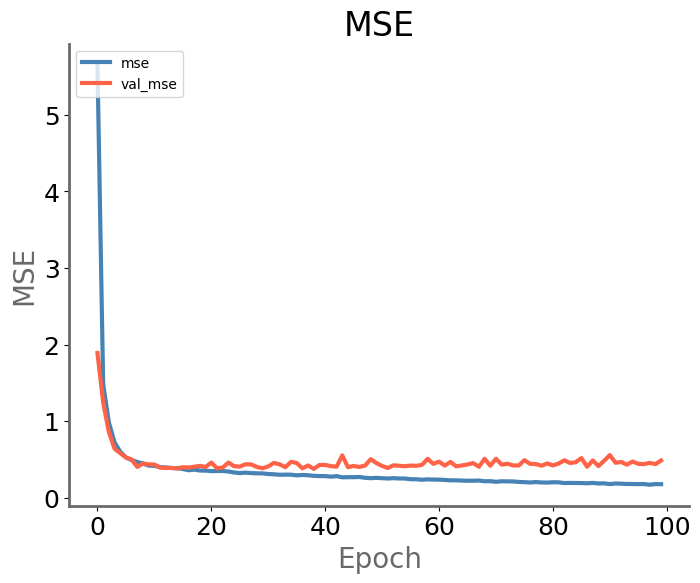

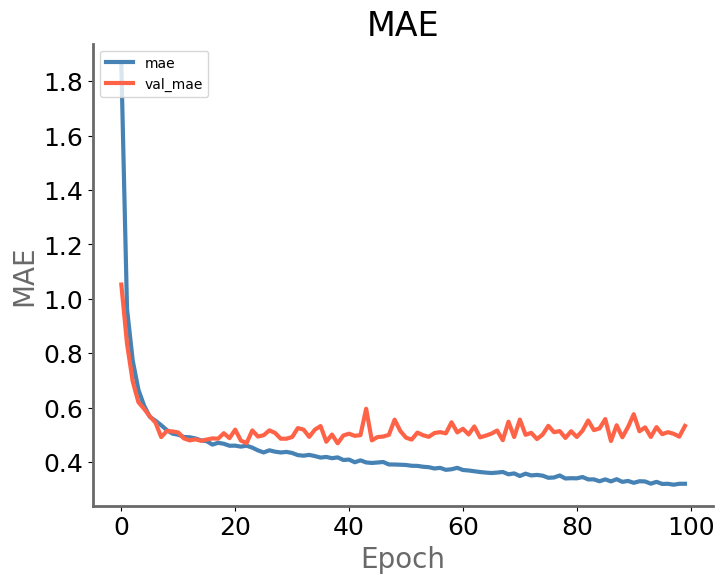

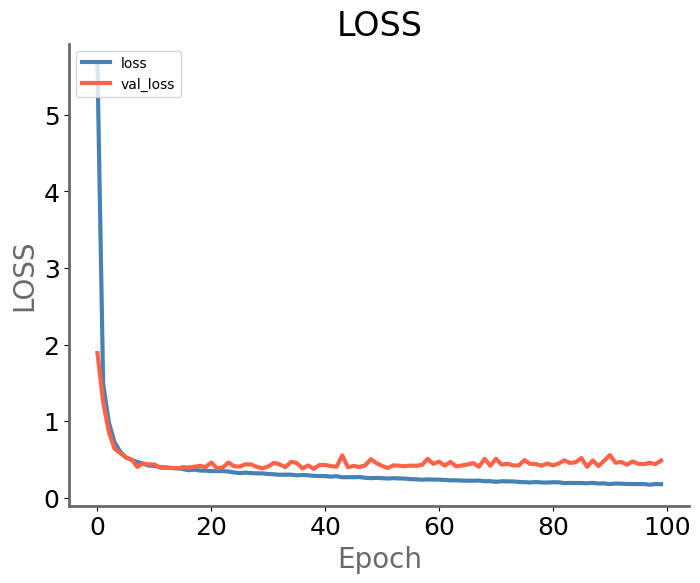

In [13]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [14]:
loaded_model = keras.models.load_model('./run/models/best_model.keras')
loaded_model.summary()
print("Loaded.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_n1 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_n2 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,988 (39.02 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,995 (19.51 KB)

Loaded.


### 7.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 1.8902
x_test / mae       : 1.0527
x_test / mse       : 1.8902


### 7.3 - Make a prediction

In [16]:
# ---- Pick n entries from our test set
n = 200
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [17]:
# ---- Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

7/7 - 0s - 3ms/step


In [18]:
# ---- Show it
print('Wine    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Wine    Prediction   Real   Delta
000        5.78       6      +0.22 
001        6.77       7      +0.23 
002        9.93       6      -3.93 
003        5.50       7      +1.50 
004        3.43       6      +2.57 
005        4.10       5      +0.90 
006        4.15       6      +1.85 
007        6.41       5      -1.41 
008        4.25       5      +0.75 
009        5.61       6      +0.39 
010        4.37       5      +0.63 
011        6.69       5      -1.69 
012        4.74       6      +1.26 
013        7.23       5      -2.23 
014        3.93       6      +2.07 
015        5.79       5      -0.79 
016        5.74       5      -0.74 
017        4.77       5      +0.23 
018        4.37       5      +0.63 
019        5.77       6      +0.23 
020        7.48       6      -1.48 
021        5.37       6      +0.63 
022        5.44       5      -0.44 
023        6.90       5      -1.90 
024        5.88       5      -0.88 
025        4.08       5      +0.92 
026        4.31       6      +

### Few questions :
- Can this model be used for red wines from Bordeaux and/or Beaujolais?
- What are the limitations of this model?
- What are the limitations of this dataset?

#### Réponses :
1. Ce modèle a été entrainé sur des vins rouges en général, il nous semble qu'il puisse être utilisé de manière plus précise pour du Bordeaux ou du Beaujolais.
2.  On a uniquement une seule sortie c'est donc un modèle de régression, pas un modèle de classification.
3.  On a peu d'échantillons uniquement 1279 échantillons ce qui est peu pour en faire une généralité. Uniquement des vins rouges, et on a ni la localisation ni la marque ce qui réduit les dimensions.

In [20]:
fidle.end()

**End time :** 22/09/25 16:44:44  
**Duration :** 00:09:10 136ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>